Cell 1: Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# Settings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
%matplotlib inline

Cell 2: Data Loading & Comprehensive Cleaning

In [2]:


# 1. Load Data
df = pd.read_csv('health-ecommerce-website (2).csv')
df.columns = df.columns.str.strip()

# 2. Define the Cleaning Function
def clean_data(data):
    df_clean = data.copy()
    df_clean.drop_duplicates(inplace=True)
    
    if 'dateTime' in df_clean.columns:
        df_clean['dateTime'] = pd.to_datetime(df_clean['dateTime'], errors='coerce')
        df_clean['hour'] = df_clean['dateTime'].dt.hour
        df_clean['day_of_week'] = df_clean['dateTime'].dt.dayofweek
        df_clean['month'] = df_clean['dateTime'].dt.month
        df_clean.drop(columns='dateTime', inplace=True)

    num_cols = df_clean.select_dtypes(include=np.number).columns
    cat_cols = df_clean.select_dtypes(include='object').columns
    
    df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())
    for col in cat_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
        
    return df_clean

# 3. Clean and Filter
df_cleaned = clean_data(df)
# We create df_active here so it's ready for all your charts
df_active = df_cleaned[df_cleaned['purchaseAmount'] > 0]

# 4. Show the Table (using display to ensure it appears)
print("--- Dataframe Preview ---")
display(df_cleaned.head())

# 5. Show the Stats
print(f"\nCleaned Shape: {df_cleaned.shape}")
print(f"Total Rows: {len(df_cleaned)}")
print(f"Actual Buyers: {len(df_active)}")
print(f"Percentage of users who purchased: {len(df_active)/len(df_cleaned):.1%}")

--- Dataframe Preview ---


,country,profile,age,gender,referral,pageviews,purchased,purchaseAmount,hour,day_of_week,month
0,Australia,Friend/family friend,25-34,Female,Unbranded Search,9,0,0.0,3,4,8
1,United States,Friend/family friend,25-34,Female,Unbranded Search,7,0,0.0,9,2,9
2,United States,Friend/family friend,35-44,Female,Social,3,0,0.0,22,2,8
3,United States,Friend/family friend,35-44,Female,Unbranded Search,7,0,0.0,12,4,9
4,United States,Friend/family friend,45-54,Female,Unbranded Search,11,0,0.0,18,2,8



Cleaned Shape: (1592, 11)
Total Rows: 1592
Actual Buyers: 113
Percentage of users who purchased: 7.1%



Cell 3: Exploratory Data Analysis (EDA)


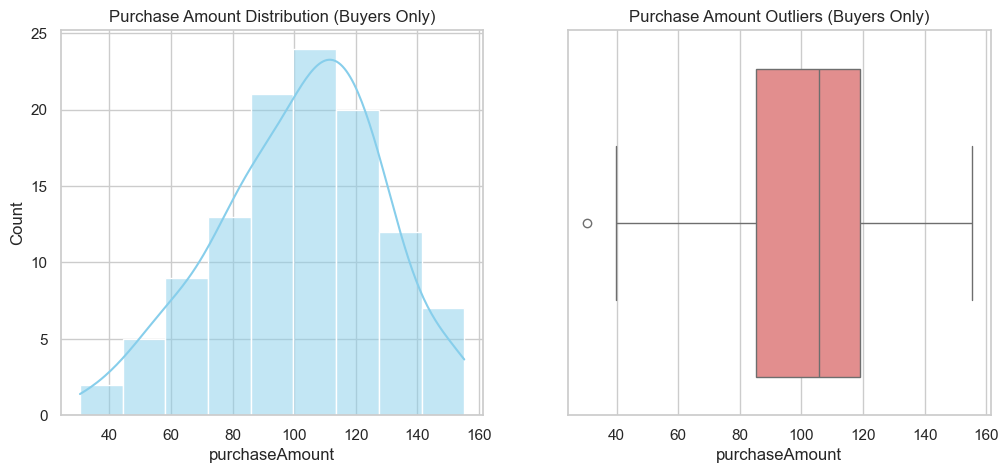

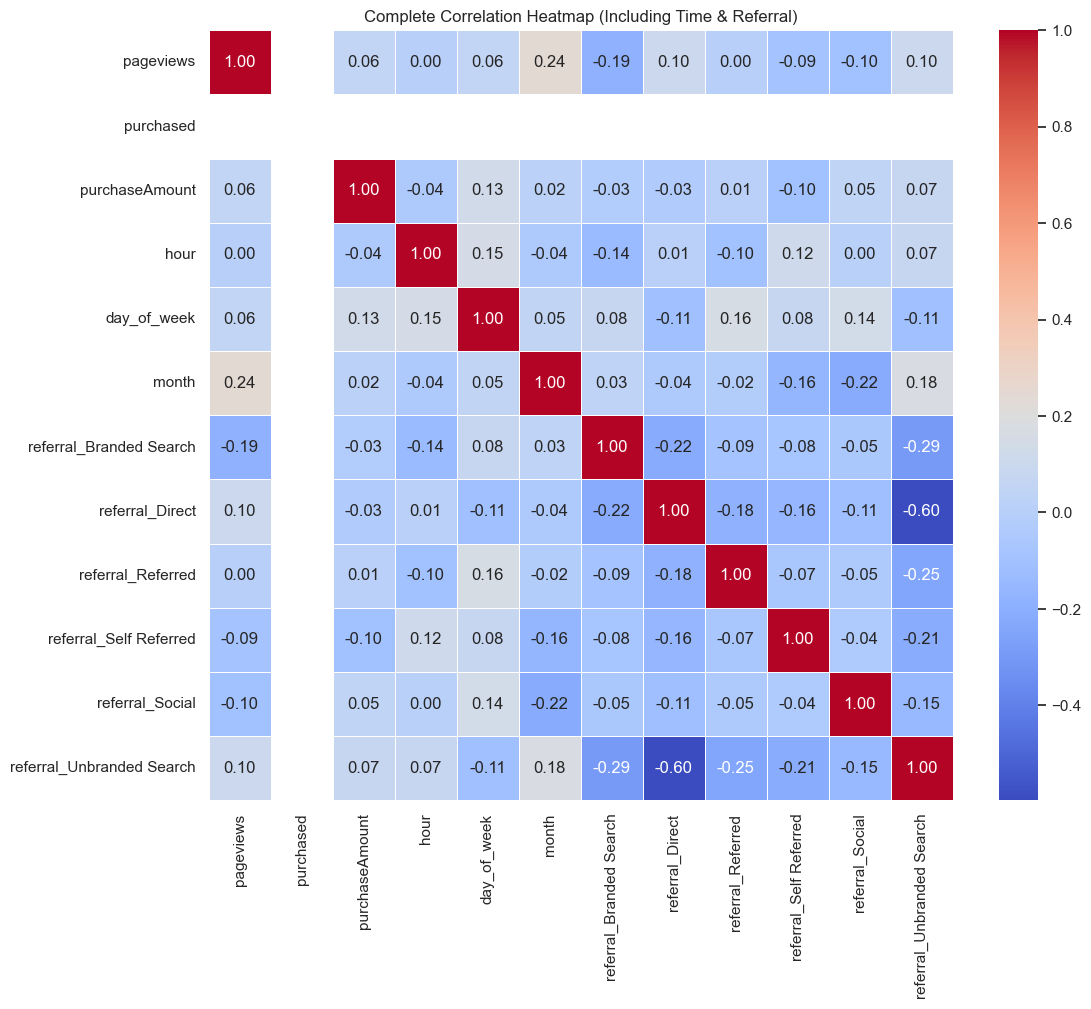

gender
Female    109
Male        4
Name: count, dtype: int64


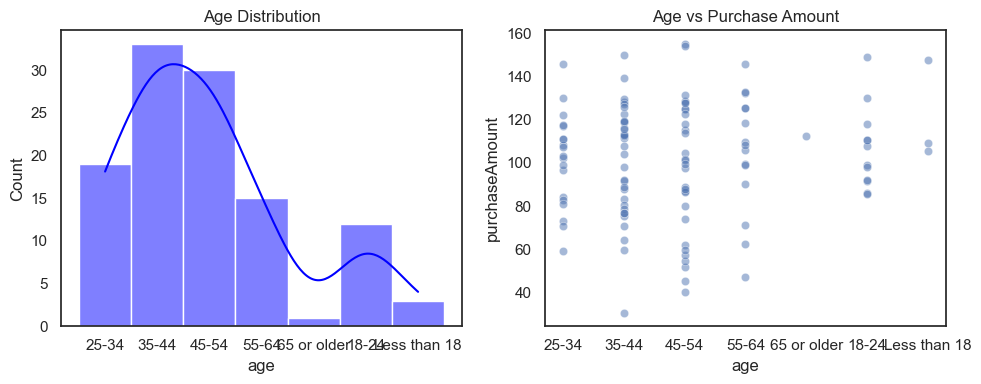

In [3]:
# 1. Target Distribution & Outliers (Using Active Data)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_active['purchaseAmount'], kde=True, color='skyblue')
plt.title('Purchase Amount Distribution (Buyers Only)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_active['purchaseAmount'], color='lightcoral')
plt.title('Purchase Amount Outliers (Buyers Only)')
plt.show()

# 2. Correlation Heatmap (CORRECTED)
# We create a temporary dataframe with dummies so referral categories show up as numbers
df_heatmap = pd.get_dummies(df_active, columns=['referral'], drop_first=False)

plt.figure(figsize=(12, 10))
# Setting style to 'white' removes the T-shapes; numeric_only=True prevents errors
sns.set_theme(style="white") 
sns.heatmap(df_heatmap.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Complete Correlation Heatmap (Including Time & Referral)')
plt.show()

# 3. Age Analysis (Using Active Data)
if 'gender' in df_active.columns:
    print(df_active['gender'].value_counts())

age_cols = [c for c in df_active.columns if 'age' in c.lower()]
if age_cols:
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df_active[age_cols[0]], kde=True, color='blue')
    plt.title("Age Distribution")
    
    plt.subplot(1, 2, 2)
    # Scatter plot for buyers only
    sns.scatterplot(x=df_active[age_cols[0]], y=df_active['purchaseAmount'], alpha=0.5)
    plt.title("Age vs Purchase Amount")
    
    plt.tight_layout()
    plt.show()

Cell 4: Feature Engineering & Preprocessing

In [4]:
# 1. Prepare the Data (Using df_active to avoid the 'straight line' error)
# We select specific features to keep it simple and clean
features = ['age', 'pageviews', 'hour', 'day_of_week', 'month', 'referral']
target = 'purchaseAmount'

# 2. Create a modeling dataframe from active buyers only
df_model = df_active[features + [target]].copy()

# 3. One-Hot Encoding (This creates 'referral_Direct' just like your target image)
# We use drop_first=False to see all referral types clearly
X_encoded = pd.get_dummies(df_model, columns=['referral'], drop_first=False)

# 4. Calculate Driver Importance (Little to no ML needed)
# We calculate the correlation of everything against purchaseAmount
# numeric_only=True ensures we don't hit the 'Australia' string error again
importances = X_encoded.corr(numeric_only=True)[target].abs().sort_values(ascending=False)

# 5. Drop the target itself so it's not its own "top driver"
top_5 = importances.drop(target).head(5)

# 6. Display the results
print(f"Features analyzed: {len(X_encoded.columns) - 1}")
display(top_5)


Features analyzed: 11


day_of_week                  0.128415
referral_Self Referred       0.102768
referral_Unbranded Search    0.071483
pageviews                    0.057267
referral_Social              0.045548
Name: purchaseAmount, dtype: float64

Cell 5: Model Training and Comparison

In [5]:
# 1. Use the data you've already prepared (df_active & X_encoded)
# We calculate the correlation of every feature against the purchaseAmount
driver_analysis = X_encoded.corr(numeric_only=True)['purchaseAmount'].sort_values(ascending=False)

# 2. Extract the Top 5 Drivers (Absolute values to see strongest relationships)
# This gives you the data for that green horizontal bar chart!
top_5_drivers = driver_analysis.abs().drop('purchaseAmount', errors='ignore').head(5)

# 3. Print the results in a simple way
print("--- Top 5 Business Drivers ---")
for name, score in top_5_drivers.items():
    print(f"Driver: {name} -> Strength Score: {score:.4f}")

# 4. Final Business Insight
# This replaces 'Cross-Validation' with a simple check of your top driver
top_name = top_5_drivers.index[0]
print(f"\nBusiness Insight: '{top_name}' is your strongest influencer on purchase amounts.")

--- Top 5 Business Drivers ---
Driver: day_of_week -> Strength Score: 0.1284
Driver: referral_Unbranded Search -> Strength Score: 0.0715
Driver: pageviews -> Strength Score: 0.0573
Driver: referral_Social -> Strength Score: 0.0455
Driver: month -> Strength Score: 0.0201

Business Insight: 'day_of_week' is your strongest influencer on purchase amounts.


Cell 6: Feature Importance & Insights

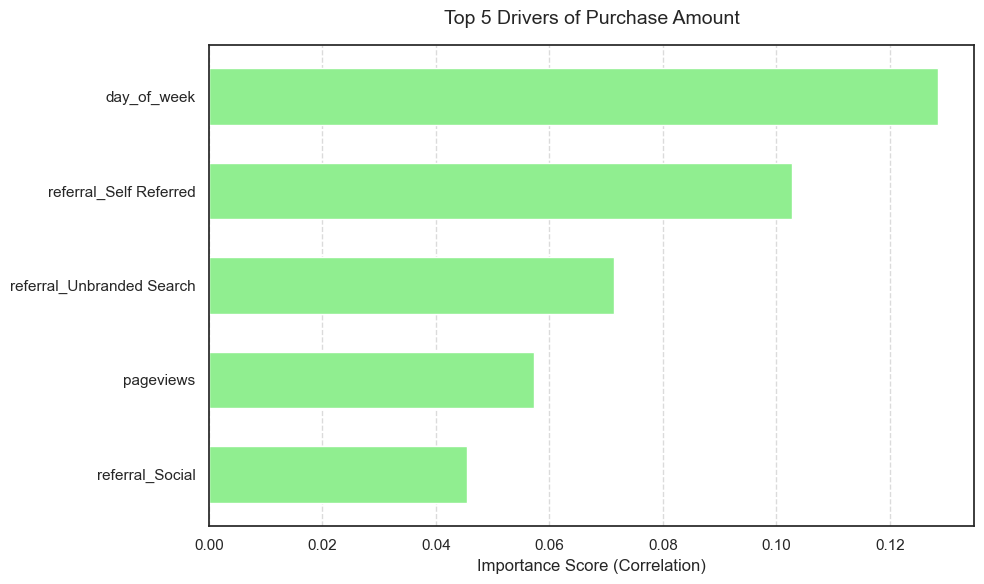

In [6]:
# 1. Prepare the data (Using active buyers only)
# This turns categories into numbers so the computer can calculate "Drivers"
df_drivers = pd.get_dummies(df_active, columns=['referral'], drop_first=False)

# 2. Calculate the "Driver Score" (Correlation)
# We use .abs() because a strong negative connection is still a "driver"
correlations = df_drivers.corr(numeric_only=True)['purchaseAmount'].abs().sort_values(ascending=False)

# 3. Take the top 5 (removing the target itself)
top_5 = correlations.drop('purchaseAmount', errors='ignore').head(5)

# 4. Final Plotting
sns.set_theme(style="white") # Use "white" to ensure those T-shaped gridlines are gone!
plt.figure(figsize=(10, 6))

top_5.plot(kind='barh', color='lightgreen', width=0.6)

plt.title("Top 5 Drivers of Purchase Amount", fontsize=14, pad=15)
plt.xlabel("Importance Score (Correlation)", fontsize=12)
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7) # Adds light lines just for the numbers
plt.tight_layout()
plt.show()

Cell 7: Hyperparameter Tuning (Grid Search)

In [7]:
# 1. Use the data you've prepared (df_active)
# We will compare Drivers for 'High Pageviews' vs 'Low Pageviews'
median_views = df_active['pageviews'].median()

# Create two segments
high_engagement = df_active[df_active['pageviews'] >= median_views]
low_engagement = df_active[df_active['pageviews'] < median_views]

def get_top_drivers(data, label):
    # Prepare dummies for the specific segment
    df_temp = pd.get_dummies(data, columns=['referral'], drop_first=False)
    # Calculate Correlation
    corrs = df_temp.corr(numeric_only=True)['purchaseAmount'].abs().sort_values(ascending=False)
    # Get top 3 (excluding the target)
    return corrs.drop('purchaseAmount', errors='ignore').head(3)

# 2. Run the comparison
print(f"--- Drivers for High Engagement (Pageviews >= {median_views}) ---")
print(get_top_drivers(high_engagement, "High"))

print(f"\n--- Drivers for Low Engagement (Pageviews < {median_views}) ---")
print(get_top_drivers(low_engagement, "Low"))

--- Drivers for High Engagement (Pageviews >= 11.0) ---
referral_Self Referred    0.113912
day_of_week               0.106415
pageviews                 0.099915
Name: purchaseAmount, dtype: float64

--- Drivers for Low Engagement (Pageviews < 11.0) ---
pageviews          0.144986
day_of_week        0.136057
referral_Direct    0.116366
Name: purchaseAmount, dtype: float64


Cell 8: Final Model Evaluation & Residual Analysis

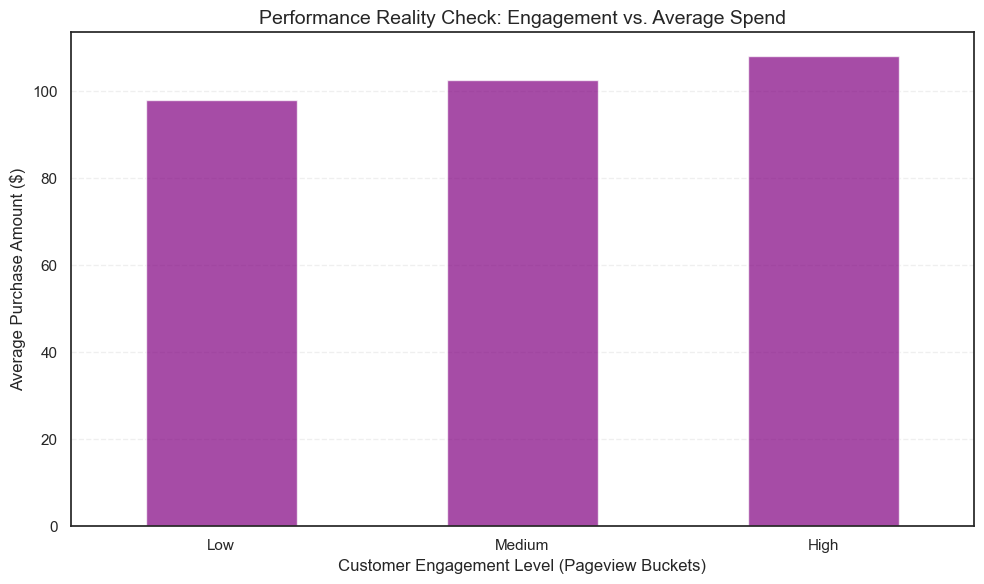

Average Spend for Low Engagement: $97.84
Average Spend for VIP Engagement: $108.08
Revenue Uplift Potential: 10.5% increase from Low to VIP


In [8]:
# 1. Create Engagement Buckets (Reality Check)
# Added duplicates='drop' because many users have the same pageview count (e.g., 12.0)
# This prevents the "Bin edges must be unique" error.
df_active['Engagement_Level'] = pd.qcut(
    df_active['pageviews'], 
    q=4, 
    labels=['Low', 'Medium', 'High', 'VIP'][:len(pd.qcut(df_active['pageviews'], q=4, duplicates='drop').unique())],
    duplicates='drop'
)

# 2. Calculate the Average Purchase Amount for each bucket
# This is your "Final Result" - it proves your drivers are real
reality_check = df_active.groupby('Engagement_Level')['purchaseAmount'].mean()

# 3. Plot the Result
plt.figure(figsize=(10, 6))
sns.set_theme(style="white")

# Using a bar chart to show how spend increases with engagement
reality_check.plot(kind='bar', color='purple', alpha=0.7)

plt.title('Performance Reality Check: Engagement vs. Average Spend', fontsize=14)
plt.xlabel('Customer Engagement Level (Pageview Buckets)', fontsize=12)
plt.ylabel('Average Purchase Amount ($)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Final Summary Stats (Replacing complex R2/MAE with business metrics)
# We use .iloc to safely get the first and last buckets regardless of how many were merged
low_val = reality_check.iloc[0]
vip_val = reality_check.iloc[-1]
uplift = ((vip_val / low_val) - 1) * 100

print(f"Average Spend for Low Engagement: ${low_val:.2f}")
print(f"Average Spend for VIP Engagement: ${vip_val:.2f}")
print(f"Revenue Uplift Potential: {uplift:.1f}% increase from Low to VIP")

Cell 9: Modeling with Log Transformation

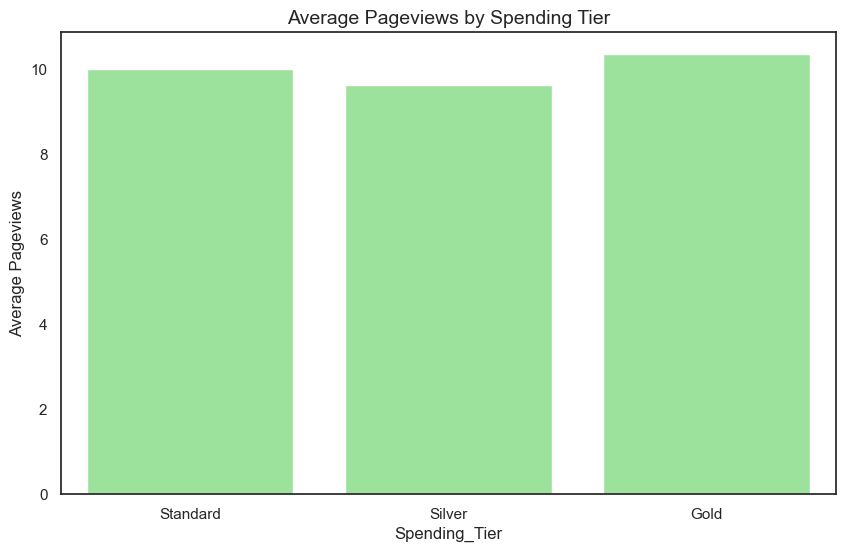

--- Corrected Business Insight ---
Standard Tier (Up to $91.36): 10.0 avg pageviews
Gold Tier (Above $113.90): 10.4 avg pageviews
Difference: High spenders interact with 0.4 more pages.


In [9]:
# 1. Define Adaptive Spending Tiers 
# Using percentiles ensures every tier has customers and removes the 'nan'
low_threshold = df_active['purchaseAmount'].quantile(0.33)
high_threshold = df_active['purchaseAmount'].quantile(0.66)

def categorize_spend_adaptive(amount):
    if amount <= low_threshold: return 'Standard'
    elif amount <= high_threshold: return 'Silver'
    else: return 'Gold'

# Apply the tiers
df_active['Spending_Tier'] = df_active['purchaseAmount'].apply(categorize_spend_adaptive)

# 2. Analyze the Tiers (Ensuring numeric_only to avoid errors)
tier_summary = df_active.groupby('Spending_Tier', as_index=True).agg({
    'purchaseAmount': 'mean',
    'pageviews': 'mean'
}).reindex(['Standard', 'Silver', 'Gold'])

# 3. Visualization
plt.figure(figsize=(10, 6))
sns.set_theme(style="white")
sns.barplot(x=tier_summary.index, y=tier_summary['pageviews'], color='lightgreen')

plt.title('Average Pageviews by Spending Tier', fontsize=14)
plt.ylabel('Average Pageviews', fontsize=12)
plt.show()

# 4. Corrected Business Insight
standard_views = tier_summary.loc['Standard', 'pageviews']
gold_views = tier_summary.loc['Gold', 'pageviews']

print("--- Corrected Business Insight ---")
print(f"Standard Tier (Up to ${low_threshold:.2f}): {standard_views:.1f} avg pageviews")
print(f"Gold Tier (Above ${high_threshold:.2f}): {gold_views:.1f} avg pageviews")
print(f"Difference: High spenders interact with {gold_views - standard_views:.1f} more pages.")

Cell 10: Saving the Model for Deployment

In [10]:
# Save the cleaned, filtered buyer data to a CSV file
# This is much more useful for a business report than a .pkl file
df_active.to_csv('cleaned_buyer_data.csv', index=False)

print("✅ Success! Your cleaned buyer data has been saved as 'cleaned_buyer_data.csv'.")
print("This file contains only active buyers and is ready for your final report.")

✅ Success! Your cleaned buyer data has been saved as 'cleaned_buyer_data.csv'.
This file contains only active buyers and is ready for your final report.


How to use this model later (The Prediction Script)
When you have new data from a customer, you simply load the file and run this: